# Projeto Final de Machine Learning
Feito por: _Henrique Bucci_ e _Marcelo Alonso_

Dados e informações: https://www.kaggle.com/datasets/marcopale/housing/data

## Etapa 0

Nesta etapa, iremos:
- Importar bibliotecas
- Carregar os dados
- Verificar se existem colunas que não fazem sentido serem colocadas no dataset final (como ID ou algum outro tipo de identificador arbitrário), olhando apenas a descrição das colunas.
- Separar o dataset em Treino-Teste

### Bibliotecas e Configurações Globais

In [212]:
import pandas as pd
import numpy as np
import joblib as jbl
from datetime import datetime
from utils import *
from objects.column_selector import ColumnSelector


from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing  import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster        import KMeans
import xgboost as xgb


In [213]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.autolayout'] = True

### Constantes

In [214]:
SEED = 420

### Carregamento e Pré-processamento dos Dados

In [215]:
dataset = load_data()
dataset.head()

,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Neste caso, a presença de duplicatas não seria intencional, uma vez que cada casa deveria ser única.  
Portanto, vamos removê-las.

In [216]:
print(f"Total de linhas antes de remover duplicatas: {dataset.shape[0]}")
dataset.drop_duplicates(inplace=True)
print(f"Total de linhas depois de remover duplicatas: {dataset.shape[0]}")

Total de linhas antes de remover duplicatas: 2930
Total de linhas depois de remover duplicatas: 2930


Como a primeira coluna é o ID da observação e a segunda é um identificador, podemos removê-las, uma vez que estes são valores arbitrários.

In [217]:
dataset = dataset.iloc[:, 2:] # Estamos removendo as duas primeiras colunas, que são o ID e o PID (Parcel identification number)

### Criando novas features

Ao analisarmos as features da forma descrita acima, vimos espaço para a criação de novas features que podem vir a ser úteis na modelagem dos dados:
- **Tot Lot Area** : `Lot Frontage + Lot Area`
- **Bsmt Tot Bath** : `Bsmt Full Bath + 0.5*Bsmt Half Bath`
- **Garage Area/Car** : `Garage Area / Garage Cars`
- **Tot Porch SF** : `Open Porch SF + Enclosed Porch + 3Ssn Porch + Screen Porch`
- **Date Sold** : `timestamp(Month Sold, Year Sold)`

In [218]:
# dataset.loc[:, 'Tot.Lot.Area'] = dataset.loc[:, 'Lot.Frontage'] + dataset.loc[:, 'Lot.Area']
dataset.loc[:, 'Bsmt.Tot.Bath'] = dataset.loc[:, 'Bsmt.Full.Bath'] + 0.5*dataset.loc[:, 'Bsmt.Half.Bath']
# dataset.loc[:, 'Garage.Area/Cars'] = dataset.loc[:, 'Garage.Area'] / dataset.loc[:, 'Garage.Cars']
dataset.loc[:, 'Tot.Porch.SF'] = dataset.loc[:, 'Open.Porch.SF'] + dataset.loc[:, 'X3Ssn.Porch'] + dataset.loc[:, 'Enclosed.Porch'] + dataset.loc[:, 'Screen.Porch']
# dataset.loc[:, 'Date.Sold'] = pd.to_datetime(dict(year=dataset['Yr.Sold'], month=dataset['Mo.Sold'], day=1)).apply(lambda x: x.timestamp())

### Train-Test Split

- A partir de agora, usaremos apenas o dataset de treino, a partição de teste será tratada como se não existisse ainda.
- O dataset total será dividido em uma proporção 80/20, uma vez que temos poucos dados (2930 no total).
- Por não se tratar de uma série temporal, podemos aplicar uma aleatoriedade na partição.

In [219]:
X, y = dataset.drop('SalePrice', axis=1), dataset.loc[:, 'SalePrice']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Etapa 1

### Análise Exploratória

Nesta parte, iremos fazer uma análise global dos dados, apenas para garantir a integridade destes.  
Assim sendo, iremos procurar entender quais são as features e target, quais são seus respectivos tipos e buscar outras informações como:
- Dados nulos
- Dados duplicados
- Outliers
- Spikes
- Erros grosseiros

Além disso, iremos buscar saber a distribuição e a "cara" de cada variável.

#### Valores Faltantes e Data Types

In [221]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2344 entries, 1157 to 1096
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS.SubClass      2344 non-null   int64  
 1   MS.Zoning        2344 non-null   object 
 2   Lot.Frontage     1945 non-null   float64
 3   Lot.Area         2344 non-null   int64  
 4   Street           2344 non-null   object 
 5   Alley            159 non-null    object 
 6   Lot.Shape        2344 non-null   object 
 7   Land.Contour     2344 non-null   object 
 8   Utilities        2344 non-null   object 
 9   Lot.Config       2344 non-null   object 
 10  Land.Slope       2344 non-null   object 
 11  Neighborhood     2344 non-null   object 
 12  Condition.1      2344 non-null   object 
 13  Condition.2      2344 non-null   object 
 14  Bldg.Type        2344 non-null   object 
 15  House.Style      2344 non-null   object 
 16  Overall.Qual     2344 non-null   int64  
 17  Overall.Cond    

#### Distribuição dos Dados

Nesta parte, iremos olhar especificamente para a distribuição dos dados.  
Nas células abaixo conseguimos ver:
- Distribuição dos dados numéricos, com os valores de `count`, `min`, `max`, `std`, `mean`, e os quartis.
- Distribuição dos dados categóricos, com os valores de `count`, `unique`, `top` (moda), `freq` (número de ocorrências da moda)

In [222]:
X_train.describe()

,MS.SubClass,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,BsmtFin.SF.2,...,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Misc.Val,Mo.Sold,Yr.Sold,Bsmt.Tot.Bath,Tot.Porch.SF
count,2344.000000,1945.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2325.000000,2343.000000,2343.000000,...,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2342.000000,2344.000000
mean,57.487201,69.387147,10130.794795,6.101109,5.558447,1971.458191,1984.436860,103.673548,436.468630,51.261204,...,47.627560,22.955205,2.389078,15.336604,2.396331,41.335751,6.234215,2007.791809,0.459223,88.308447
std,42.697657,23.645307,7021.928686,1.413162,1.103673,30.424244,20.945233,181.229599,453.039342,170.845327,...,67.760644,61.518987,23.262509,54.365229,37.264067,378.295773,2.728457,1.305689,0.521169,104.923186
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000
25%,20.000000,59.000000,7500.000000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,0.000000,0.000000
50%,50.000000,68.000000,9504.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,362.000000,0.000000,...,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,0.000000,50.000000
75%,70.000000,80.000000,11618.250000,7.000000,6.000000,2001.000000,2004.000000,166.000000,729.000000,0.000000,...,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,1.000000,135.000000
max,190.000000,313.000000,164660.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,742.000000,584.000000,407.000000,490.000000,800.000000,12500.000000,12.000000,2010.000000,3.000000,1027.000000


In [223]:
X_train.describe(include=np.object_)

,MS.Zoning,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,...,Garage.Type,Garage.Finish,Garage.Qual,Garage.Cond,Paved.Drive,Pool.QC,Fence,Misc.Feature,Sale.Type,Sale.Condition
count,2344,2344,159,2344,2344,2344,2344,2344,2344,2344,...,2212,2211,2211,2211,2344,11,459,85,2344,2344
unique,7,2,2,4,4,3,5,3,28,9,...,6,3,5,5,3,4,4,4,10,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1815,2334,98,1476,2099,2341,1708,2231,349,2037,...,1387,977,2090,2125,2128,4,260,77,2018,1908


##### Gráficos

In [224]:
plot_distribution(X_train, 'x_train_original.png')

Gráfico salvo em ./graphs/x_train_original.png


Para uma visualização melhor fizemos este gráfico, e nele podemos ver que diversas features que são estritamente positivas e possuem uma cauda direita alongada.  
  
Neste caso, o ideal é transformá-las em distribuições normais.  

<img src="./graphs/x_train_original.png" alt="drawing" width="700"/>  
  
Assim sendo, aplicaremos log nas colunas que possuem uma cauda direita, e iremos fazer um gráfico para visualizarmos as diferenças.

In [225]:
"""
Pegando os nomes das colunas numéricas, categóricas e com cauda direita alongada 
para fazermos as transformações necessárias.
Estas variáveis serão utilizadas durante todo o notebook.
"""
right_skewed, numerical, categorical = get_column_subsets(X_train)

In [226]:
X_train_log = X_train.copy()
X_train_log[right_skewed] = np.log1p(X_train_log[right_skewed])

plot_distribution(X_train_log.select_dtypes(include='number'), 'x_train_log.png')
plot_distribution(X_train_log[right_skewed], 'x_train_log_only.png')
plot_distribution(X_train[right_skewed], 'x_train_original_sk_only.png')

Gráfico salvo em ./graphs/x_train_log.png
Gráfico salvo em ./graphs/x_train_log_only.png
Gráfico salvo em ./graphs/x_train_original_sk_only.png


Ao aplicar log nas colunas:

In [227]:
right_skewed

['Lot.Frontage',
 'Lot.Area',
 'Mas.Vnr.Area',
 'BsmtFin.SF.1',
 'BsmtFin.SF.2',
 'Bsmt.Unf.SF',
 'Total.Bsmt.SF',
 'X1st.Flr.SF',
 'X2nd.Flr.SF',
 'Gr.Liv.Area',
 'Garage.Area',
 'Wood.Deck.SF',
 'Open.Porch.SF',
 'Enclosed.Porch',
 'Screen.Porch',
 'X3Ssn.Porch',
 'Tot.Porch.SF']

Uma vez que os dados estão distribuídos de uma forma mais próxima a uma distribuição normal, o peso de features com valores muito altos é reduzido, fazendo também com que as difereças sejam contadas de forma multiplicativa ao invés de aditiva, destacando mudanças proporcionais no lugar de mudanças absolutas, facilitando a interpretação dos dados pelos modelos. 

#### Antes e Depois da Normalização

<img src="./graphs/x_train_original_sk_only.png" alt="drawing" width="700"/> <img src="./graphs/x_train_log_only.png" alt="drawing" width="700"/>  

#### Resultado final das features após a normalização por `log1p()`

<img src="./graphs/x_train_log.png" alt="drawing" width="700"/>

#### Distribuição do Target e Remoção de Outliers

Primeiro, para ajudar a encontrar os outliers no conjunto de treino, decidimos vizualizar o gráfico de correlações entre as features numéricas, incluindo o **target**

In [228]:
X_train_y_train = pd.concat([X_train_log.select_dtypes(include='number'), np.log1p(y_train)], axis=1)

display(X_train_y_train \
    .corr() \
    .style \
    .background_gradient(cmap='coolwarm', axis=None) \
    .set_table_attributes('style="width: 50%;"') \
    .set_caption('Correlação entre variáveis numéricas'))

,MS.SubClass,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,TotRms.AbvGrd,Fireplaces,Garage.Yr.Blt,Garage.Cars,Garage.Area,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Misc.Val,Mo.Sold,Yr.Sold,Bsmt.Tot.Bath,Tot.Porch.SF,SalePrice
MS.SubClass,1.000000,-0.540551,-0.508866,0.038483,-0.064628,0.030041,0.044609,0.002414,-0.014155,-0.078304,-0.142440,-0.077176,-0.297293,0.364871,0.018203,0.074812,0.015699,0.005202,0.135442,0.164769,-0.028485,0.266373,0.032888,-0.042730,0.095880,-0.054884,-0.121999,0.018133,0.005684,-0.034618,-0.016667,-0.054915,-0.005785,-0.024822,-0.009216,-0.019455,0.016998,-0.047676,-0.076828
Lot.Frontage,-0.540551,1.000000,0.770277,0.170414,-0.044181,0.080996,0.081486,0.144269,0.036585,0.023327,0.079725,0.084476,0.467955,-0.113332,-0.000711,0.328939,0.084132,-0.032718,0.159419,-0.008103,0.252203,0.024728,0.343612,0.218948,0.055432,0.276555,0.167338,0.082535,0.138237,-0.007282,0.003837,0.081878,0.102581,0.026508,0.026095,-0.001083,0.076881,0.146100,0.338220
Lot.Area,-0.508866,0.770277,1.000000,0.135700,-0.030886,0.032455,0.047469,0.088327,0.057300,0.068778,0.032756,0.080259,0.470873,-0.063744,-0.001245,0.361038,0.110220,0.006729,0.160336,0.032786,0.258840,-0.006082,0.344066,0.268877,0.009335,0.266812,0.187591,0.119167,0.117159,0.020167,0.005156,0.080393,0.085319,0.047702,0.018991,-0.027093,0.112475,0.136922,0.358260
Overall.Qual,0.038483,0.170414,0.135700,1.000000,-0.096968,0.595790,0.569967,0.425652,0.097365,-0.079877,0.251323,0.354340,0.454833,0.138739,-0.062337,0.584954,0.154944,-0.047893,0.515968,0.264894,0.048130,-0.158386,0.368456,0.385523,0.572939,0.594660,0.375883,0.300423,0.457280,-0.191446,0.014498,0.007924,0.028400,-0.033378,0.035587,-0.022358,0.144902,0.292401,0.825515
Overall.Cond,-0.064628,-0.044181,-0.030886,-0.096968,1.000000,-0.352895,0.052825,-0.148801,0.063654,0.090202,-0.052374,-0.015676,-0.142035,0.035141,0.008242,-0.127942,-0.024445,0.075232,-0.201157,-0.086025,-0.002435,-0.074627,-0.084782,-0.008977,-0.325443,-0.166332,0.003189,-0.017333,-0.140513,0.113101,0.044210,0.052880,-0.009016,0.034780,-0.007028,0.049616,-0.007270,-0.031216,-0.039234
Year.Built,0.030041,0.080996,0.032455,0.595790,-0.352895,1.000000,0.614972,0.394687,0.163894,-0.057995,0.078063,0.212915,0.290046,-0.082136,-0.146551,0.261029,0.192912,-0.017536,0.456741,0.279545,-0.069325,-0.145581,0.095308,0.155599,0.829000,0.523575,0.323211,0.304225,0.395498,-0.470074,0.013229,-0.068275,0.010582,-0.034134,0.006105,-0.021235,0.190106,0.033770,0.614506
Year.Remod.Add,0.044609,0.081486,0.047469,0.569967,0.052825,0.614972,1.000000,0.226717,0.011449,-0.101118,0.158493,0.200774,0.224731,0.083599,-0.062176,0.334994,0.114196,-0.044615,0.454941,0.223110,-0.027324,-0.134359,0.191048,0.123060,0.652659,0.425506,0.218101,0.284107,0.397174,-0.271064,0.037072,-0.058234,-0.015634,-0.035868,0.023736,0.030779,0.104649,0.165445,0.587773
Mas.Vnr.Area,0.002414,0.144269,0.088327,0.425652,-0.148801,0.394687,0.226717,1.000000,0.204007,-0.029886,0.092235,0.193690,0.359613,-0.048691,-0.082889,0.320152,0.144500,0.038940,0.266851,0.141798,0.059647,-0.060071,0.220114,0.263860,0.309443,0.376303,0.233974,0.146135,0.233710,-0.173289,0.036032,0.049272,0.008842,-0.000775,0.012318,-0.005762,0.154436,0.107453,0.439504
BsmtFin.SF.1,-0.014155,0.036585,0.057300,0.097365,0.063654,0.163894,0.011449,0.204007,1.000000,0.187383,-0.254174,0.298568,0.184635,-0.192376,-0.063544,-0.014691,0.590853,0.119288,-0.087497,-0.010868,-0.122297,-0.142733,-0.109812,0.198323,0.054792,0.088442,0.144954,0.127653,0.010182,-0.119700,0.067808,0.094883,0.019576,0.029558,-0.018038,0.038351,0.622113,-0.047253,0.231433
BsmtFin.SF.2,-0.078304,0.023327,0.068778,-0.079877,0.090202,-0.057995,-0.101118,-0.029886,0.187383,1.000000,-0.275182,0.079551,0.076548

Agora, vamos remover os outliers de acordo com o target apenas, seguindo a distribuição normal do target em *log1p*

In [229]:
y_hist(y_train, 'target distribution')

Gráfico salvo em ./graphs/target distribution


<img src="./graphs/target distribution.png" alt="drawing" width="70%"/>

Quando temos uma diferença entre dois valores, tal diferença recebe sua significância relativa a dimensão do valor.

Para exemplificar:
- para uma casa de 20 mil dólares, uma diferença de 5 mil dólares representa 25% de seu valor original
- para uma casa de 700 mil dólares, uma diferença de 5 mil dólares representa 0.7% de seu valor original

O log1p balancia o peso de diferenças de acordo com a dimensão dos dados, equilibrando o número de outliers retirados em ambos os lados, representados no exemplo acima.

In [230]:
# Agora, basta remover os outliers encontrados no target do dataset
print(f"Total de linhas antes de remover outliers: {X_train.shape[0]}")
X_train, y_train = remove_outliers(X_train, y_train)
print(f"Total de linhas depois de remover outliers: {X_train.shape[0]}")

Total de linhas antes de remover outliers: 2344
Total de linhas depois de remover outliers: 2298


### Selecionando as features 

Para selecionar as features, decidimos utilizar um `RandomForestRegressor`, uma vez que tal modelo possui o atributo `.feature_importances_`, que retorna um número de 0 a 1, que somados resultam em 1, ou seja, a porcentagem da imfluência de cada feature na decisão final do modelo.

Ao obtermos o dataframe de feature importances, iremos pegar as 11 numéricas mais influentes, em conjunto com as 4 categóricas mais influêntes para utilizarmos ao longo do nosso treinamento seguinte.

Primeiro, para rodarmos o `RandomForest`, precisamos montar uma pipeline de pré-processamento dos dados:

In [231]:
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

c_log_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('log', FunctionTransformer(np.log1p, validate=False, feature_names_out='one-to-one')),
])

cat_pipe = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessing_pipeline = ColumnTransformer(
    transformers = [
        ('num', num_pipe, numerical),
        ('clog', c_log_pipe, right_skewed),
        ('cat', cat_pipe, categorical)
    ],
    remainder='passthrough'
)

preprocessing_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['MS.SubClass', 'Overall.Qual', 'Overall.Cond',
                                  'Year.Built', 'Year.Remod.Add',
                                  'Low.Qual.Fin.SF', 'Bsmt.Full.Bath',
                                  'Bsmt.Half.Bath', 'Full.Bath', 'Half.Bath',
                                  'Bedroom.AbvGr', 'Kitchen.AbvGr',
                                  'TotRms.AbvGrd', 'Fireplaces',
                                  'Garage.Yr.Blt', 'Garage.Cars'...
                                  'Land.Contour', 'Utilities', 'Lot.Config',
                                  'Land.Slope', 'Neighborhood', 'Condition.1',
                                  'Condition.2', 'Bldg.Type', 'House.Style',
                                  'Roof.Style', 'Roof.Matl', 'Exterior.1st',
                                  'Exterior.2nd', 'Mas.Vnr.Type', 'Exter.Qual',
                                  'Exter.Cond', 'Foundation', 'Bsmt.Qual',
                                  'Bsmt.Cond', 'Bsmt.Exposure',
                                  'BsmtFin.Type.1', 'BsmtFin.Type.2', 'Heating',
                                  'Heating.QC', 'Central.Air', 'Electrical', ...])])

Esta pipeline é simples, 

Para os dados numéricos, estamos apenas preenchendo os valores nulos com o `SimpleImputer`, já que as *Random Forests*, por serem um método ensemble de *DecisionTrees*, herdam a propriedade de *nonparametric model*, logo, não necessitam de uma quantidade pré-determinada de parâmetros, o que facilita a adaptação aos dados de treino.

Os dados de features classificadas como *right_skewed*, estamos, além do procedimento normal dos dados numéricos, normalizando com o *log1p* dos dados. Tal procedimento, não é necessário quando se trata de *Random Forests*, porém, achamos que seria bom colocar, uma vez que pretendemos utilizar esta regularização na pipeline dos modelos mais tarde.

Os dados categóricos estão passando por um `OneHotEncoder`, para tratar as features categóricas como valores numéricos (0 e 1).

----

Agora basta montar o nosso selecionador de features, para isso, iremos criar uma nova pipeline, que acopla a pipeline anterior de pré-processamento, com o *RandomForestRegressor*

In [232]:
rnd_clf = RandomForestRegressor(
    n_estimators=700,
    max_leaf_nodes=16,
    random_state=SEED,
    n_jobs=1
)

feature_selector = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('regressor', rnd_clf),
])

feature_selector.fit(X_train, np.log1p(y_train))

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['MS.SubClass',
                                                   'Overall.Qual',
                                                   'Overall.Cond', 'Year.Built',
                                                   'Year.Remod.Add',
                                                   'Low.Qual.Fin.SF',
                                                   'Bsmt.Full.Bath',
                                                   'Bsmt.Half.Bath',
                                                   'Full.Bath', 'Half.Bath',
                                                   'Bedroom.AbvGr',
                                                   'Kitchen.AbvGr',
                                                   'TotRms.AbvGrd',
                                                   'Fireplac...
                                                   'Bldg.Type', 'House.Style',
                                                   'Roof.Style', 'Roof.Matl',
                                                   'Exterior.1st',
                                                   'Exterior.2nd',
                                                   'Mas.Vnr.Type', 'Exter.Qual',
                                                   'Exter.Cond', 'Foundation',
                                                   'Bsmt.Qual', 'Bsmt.Cond',
                                                   'Bsmt.Exposure',
                                                   'BsmtFin.Type.1',
                                                   'BsmtFin.Type.2', 'Heating',
                                                   'Heating.QC', 'Central.Air',
                                                   'Electrical', ...])])),
                ('regressor',
                 RandomForestRegressor(max_leaf_nodes=16, n_estimators=700,
                                       n_jobs=1, random_state=420))])

Após fazer o `.fit()` do nosso modelo, conseguimos pegar as 15 features mais importantes de acordo com ele.  
Neste projeto, iremos utilizar 4 features categóricas e 11 features numéricas. Sendo assim, ordenamos as features por importância e fizemos a seleção por tipo.

As colunas a serem utilizadas pelo modelo foram guardadas na variável `X_feats`.

In [233]:
importances = feature_selector.named_steps['regressor'].feature_importances_

feature_names = preprocessing_pipeline.get_feature_names_out()
feature_importances_df = pd.DataFrame(zip(feature_names, importances), columns=['Feature', 'Importance']) \
    .sort_values(by='Importance', ascending=False)

feature_importances_df = aggregate_categorical_importances(feature_importances_df.set_index('Feature'))

top4_cat_features = [x for x in feature_importances_df.index if 'cat__' in x][:4]
top11_num_features = [x for x in feature_importances_df.index if 'clog__' in x or 'num__' in x][:11]

top15_features = top4_cat_features + top11_num_features

X_feats = [feat.split('__')[1] for feat in top15_features]

X_feats

['Garage.Type',
 'MS.Zoning',
 'Bsmt.Qual',
 'Central.Air',
 'Overall.Qual',
 'Gr.Liv.Area',
 'Garage.Cars',
 'Total.Bsmt.SF',
 'Garage.Area',
 'Year.Built',
 'X1st.Flr.SF',
 'Lot.Area',
 'BsmtFin.SF.1',
 'Year.Remod.Add',
 'Overall.Cond']

## Etapa 2

Nesta etapa, faremos a seleção do melhor modelo.
Para esta tarefa, decidimos utilizar o `RandomizedSearchCV`, que testa múltiplos modelos e parâmetros em um mesmo conjunto de testes assim como o `GridSearchCV`, porém, o `RandomizedSearchCv` escolhe, dado o parâmetro `n_iter`, `n_iter` combinações de modelos e híper-parâmetros.

A vantagem de utilizar o `RandomizedSearchCV` é a velocidade do processo de treino, teste e avaliação, dado que este não itera sobre todas as combinações possíveis.


### Colunas por Categoria

Vamos começar dividindo as features escolhidas em três grupos, as numéricas, categóricas e as right_skewed , que serão as features (numéricas) que anteriormente decidimos normalizar aplicando o `log1p()`.

In [234]:
right_skewed, numerical, categorical = split_by_prefix(top15_features)

### Pipelines de Preprocessamento

Agora, iremos montar as pipelines referentes a cada um dos grupos de features definidos acima:

- Categóricas:
    - SimpleImputer $\rightarrow$ Preenche os valores faltantes na coluna do dataset por um valor constante "MISSING"
    - OneHotEncoder $\rightarrow$ Transforma features categóricas em arrays numéricos binários, fazendo com que estas colunas sejam interpretadas de forma numérica.

- Numéricas:
    - SimpleImputer $\rightarrow$ Preenche os valores faltantes na coluna do dataset pela mediana da coluna
    - StandartScaler $\rightarrow$ Padroniza os dados fazando com que tenham média zero e desvio-padrão 1
    - PolynomialFeatures $\rightarrow$ adiciona as potências de cada feature no dataset como novas features

- Numéricas:
    - SimpleImputer $\rightarrow$ Preenche os valores faltantes na coluna do dataset pela mediana da coluna
    - StandartScaler $\rightarrow$ Padroniza os dados fazando com que tenham média zero e desvio-padrão 1
    - PolynomialFeatures $\rightarrow$ adiciona as potências de cada feature no dataset como novas features

Depois, adicionamos o *Kmeans*, criando variáveis que capturam a afinidade da amostra com clusters da entrada, desta forma, enriquecemos além do *polynomial features*, de um modo baseado em agrupamentos.

In [235]:
# Pipeline para as features em right_skewed
log_pipe = Pipeline([
    ("impute",  SimpleImputer(strategy="median")),
    ("log1p",   FunctionTransformer(np.log1p, validate=False)),
    ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
])

# Pipeline para as features numéricas (não right_skewed)
num_pipe = Pipeline([
    ("impute",  SimpleImputer(strategy="median")),
    # scaler will be overridden in grid
    ("scale",   StandardScaler()),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
])

# Pipeline para as features categóricas
cat_pipe = Pipeline([
    ("impute",  SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore", drop="first")),
])


# Pipeline de pré-processamento base
base_preprocessor = ColumnTransformer([
    ("skewed",   log_pipe,  right_skewed),
    ("numeric",  num_pipe,  numerical),
    ("categorical", cat_pipe, categorical),
], remainder="drop")


# Pipeline para o KMeans
# (será utilizado como feature engineering, similar ao PolynomialFeatures)
kmeans_branch = Pipeline([
    ("pre", base_preprocessor),
    ("cluster", KMeans())
])

In [236]:
# FeatureUnion para unir as features do KMeans com as features do preprocessor
full_features = FeatureUnion([
    ("base", base_preprocessor),
    ("kmeans", kmeans_branch),
])

Agora, criamos uma pipeline para ser utilizada como modelo pelo *RandomizedSearchCV*

Então, adicionamos um transformador que filtra as features do dataset recebido de acordo com as 15 selecionadas anteriormente, à partir da função `ColorSelector()`.

In [237]:
column_selector = ColumnSelector(columns=X_feats)

pipe = Pipeline([
    ("select_columns", column_selector),
    ("features",  full_features),
    ("regressor", DummyRegressor())
], memory="~/cachedir")

pipe

Pipeline(memory='~/cachedir',
         steps=[('select_columns',
                 ColumnSelector(columns=['Garage.Type', 'MS.Zoning',
                                         'Bsmt.Qual', 'Central.Air',
                                         'Overall.Qual', 'Gr.Liv.Area',
                                         'Garage.Cars', 'Total.Bsmt.SF',
                                         'Garage.Area', 'Year.Built',
                                         'X1st.Flr.SF', 'Lot.Area',
                                         'BsmtFin.SF.1', 'Year.Remod.Add',
                                         'Overall.Cond'])),
                ('features',
                 FeatureUnion(transformer_list=[('base',
                                                 ColumnTr...
                                                                                                   ['Overall.Qual',
                                                                                                    'Garage.Cars',
                                                                                                    'Year.Built',
                                                                                                    'Year.Remod.Add',
                                                                                                    'Overall.Cond']),
                                                                                                  ('categorical',
                                                                                                   Pipeline(steps=[('impute',
                                                                                                                    SimpleImputer(fill_value='MISSING',
                                                                                                                                  strategy='constant')),
                                                                                                                   ('ohe',
                                                                                                                    OneHotEncoder(drop='first',
                                                                                                                                  handle_unknown='ignore'))]),
                                                                                                   ['Garage.Type',
                                                                                                    'MS.Zoning',
                                                                                                    'Bsmt.Qual',
                                                                                                    'Central.Air'])])),
                                                                 ('cluster',
                                                                  KMeans())]))])),
                ('regressor', DummyRegressor())])

Faremos uma função para computar a raíz do erro quadrado médio para utilizar como medida de performance dos modelos 

In [238]:
rmse = make_scorer(lambda y_true, y_pred: 
                   np.sqrt(mean_squared_error(y_true, y_pred)),
                   greater_is_better=False)

Para montar o nosso `RandomizedSearchCv`, falta montar uma lista de distribuição dos parâmetros, para que o *RandomizedSearchCV* possa utilizar para fazer as combinações de híper-parâmetros e modelos, substituindo no modelo `pipe` montado acima

In [239]:
param_distributions = [

    # ─────────── baseline regressors ───────────
    {
      "regressor": [DummyRegressor(), LinearRegression()],
      "features__kmeans__cluster__n_clusters": [1, 2, 3, 4],
      "features__base__numeric__poly__degree": [1],
      "features__base__skewed__poly__degree": [1],
      "features__kmeans__pre__numeric__poly__degree": [1],
      "features__kmeans__pre__skewed__poly__degree": [1],
      "features__base__numeric__scale": [StandardScaler(), MinMaxScaler()]
    },

    # ─────────── Ridge & Lasso ───────────
    {
      "regressor": [Lasso(), Ridge()],
      "regressor__alpha": [0.1, 1, 10, 100],
      "features__kmeans__cluster__n_clusters": [1, 2, 3, 4],
      "features__base__numeric__poly__degree": [1, 2],
      "features__base__skewed__poly__degree": [1, 2],
      "features__kmeans__pre__numeric__poly__degree": [1, 2],
      "features__kmeans__pre__skewed__poly__degree": [1, 2],
      "features__base__numeric__scale": [StandardScaler(), MinMaxScaler()],
    },

    # ────────── ElasticNet ──────────
    {
      "regressor": [ElasticNet()],
      "regressor__alpha": [0.1, 1, 10, 100],
      "regressor__l1_ratio": [0.1, 0.5, 0.9],
      "features__kmeans__cluster__n_clusters": [1, 2, 3, 4],
      "features__base__numeric__poly__degree": [1, 2],
      "features__base__skewed__poly__degree": [1, 2],
      "features__kmeans__pre__numeric__poly__degree": [1, 2],
      "features__kmeans__pre__skewed__poly__degree": [1, 2],
      "features__base__numeric__scale": [None, StandardScaler(), MinMaxScaler()],
    },

    # ───────── RandomForest ─────────
    {
      "regressor": [RandomForestRegressor(random_state=SEED)],
      "regressor__n_estimators": [300, 500, 700],
      "regressor__max_depth": [None, 10, 20, 30],
      "regressor__min_samples_split": [2, 5, 10],
      "regressor__bootstrap": [True, False],
      "features__kmeans__cluster__n_clusters": [1, 2, 3, 4],
      "features__base__numeric__poly__degree": [1, 2],
      "features__base__skewed__poly__degree": [1, 2],
      "features__kmeans__pre__numeric__poly__degree": [1, 2],
      "features__kmeans__pre__skewed__poly__degree": [1, 2],
      "features__base__numeric__scale": [None, StandardScaler(), MinMaxScaler()],
    },

    # ─────── GradientBoosting ───────
    {
      "regressor": [GradientBoostingRegressor(random_state=SEED)],
      "regressor__n_estimators": [100, 150, 200],
      "regressor__learning_rate": [0.01, 0.05, 0.1],
      "regressor__max_depth": [3, 5, 7],
      "regressor__subsample": [0.6, 0.8, 1.0],
      "features__kmeans__cluster__n_clusters": [1, 2, 3, 4],
      "features__base__numeric__poly__degree": [1, 2],
      "features__base__skewed__poly__degree": [1, 2],
      "features__kmeans__pre__numeric__poly__degree": [1, 2],
      "features__kmeans__pre__skewed__poly__degree": [1, 2],
      "features__base__numeric__scale": [None, StandardScaler(), MinMaxScaler()],
    },

    # ─────────── XGBoost ───────────
    {
      "regressor": [xgb.XGBRegressor(random_state=SEED, objective="reg:squarederror")],
      "regressor__n_estimators": [50, 100, 150],
      "regressor__learning_rate": [0.01, 0.05, 0.1],
      "regressor__max_depth": [3, 5, 7, 10],
      "regressor__subsample": [0.6, 0.8, 1.0],
      "regressor__colsample_bytree": [0.6, 0.8, 1.0],
      "regressor__reg_alpha": [0, 0.1, 1, 10],
      "regressor__reg_lambda": [1, 10, 100],
      "features__kmeans__cluster__n_clusters": [1, 2, 3, 4],
      "features__base__numeric__poly__degree": [1, 2],
      "features__base__skewed__poly__degree": [1, 2],
      "features__kmeans__pre__numeric__poly__degree": [1, 2],
      "features__kmeans__pre__skewed__poly__degree": [1, 2],
      "features__base__numeric__scale": [None, StandardScaler(), MinMaxScaler()],
    },
]

Transformamos y_train com o log1p como explicado no início do notebook.

In [240]:
y_train_log = np.log1p(y_train.copy())

Só falta montar o *RandomizedSearchCV* e dar fit

In [241]:
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=rmse,
    cv=3,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
    return_train_score=True,
)

search.fit(X_train, y_train_log)
print("Best RMSE:", -search.best_score_)
print("Best params:", search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RMSE: 0.12004641793892361
Best params: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 10, 'regressor__reg_alpha': 1, 'regressor__n_estimators': 100, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.6, 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strateg

Resultados do *RandomizedSearchCV*, ordenados pelo rank no teste.

In [242]:
cv_results_df = pd.DataFrame(search.cv_results_)  
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
cv_results_df = cv_results_df[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']]

cv_results_df

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
15,"{'regressor__subsample': 0.8, 'regressor__reg_...",-0.077438,0.001076,-0.120046,0.001699,1
13,"{'regressor__subsample': 0.6, 'regressor__reg_...",-0.088908,0.001038,-0.120563,0.003457,2
8,"{'regressor__subsample': 1.0, 'regressor__reg_...",-0.076191,0.000353,-0.122539,0.003404,3
14,"{'regressor__subsample': 0.8, 'regressor__reg_...",-0.075708,0.000415,-0.124918,0.001342,4
12,"{'regressor__subsample': 0.6, 'regressor__reg_...",-0.108856,0.001250,-0.130644,0.002112,5
4,"{'regressor__subsample': 0.8, 'regressor__reg_...",-0.122159,0.000708,-0.137458,0.002979,6
17,"{'regressor__subsample': 1.0, 'regressor__reg_...",-0.114352,0.000951,-0.138515,0.001932,7
10,"{'regressor__subsample': 0.8, 'regressor__reg_...",-0.131094,0.000793,-0.143439,0.001688,8
2,"{'regressor__subsample': 0.6, 'regressor__reg_...",-0.132127,0.000621,-0.144864,0.001531,9
16,"{'regressor__subsample': 0.8, 'regressor__reg_...",-0.138034,0.000266,-0.149920,0.003045,10


Escolhemos então, o melhor modelo

In [243]:
chosen_model = search.best_estimator_

Vamos dar fit no modelo escolhido

In [244]:
chosen_model.fit(X_train, y_train_log)

Pipeline(memory='~/cachedir',
         steps=[('select_columns',
                 ColumnSelector(columns=['Garage.Type', 'MS.Zoning',
                                         'Bsmt.Qual', 'Central.Air',
                                         'Overall.Qual', 'Gr.Liv.Area',
                                         'Garage.Cars', 'Total.Bsmt.SF',
                                         'Garage.Area', 'Year.Built',
                                         'X1st.Flr.SF', 'Lot.Area',
                                         'BsmtFin.SF.1', 'Year.Remod.Add',
                                         'Overall.Cond'])),
                ('features',
                 FeatureUnion(transformer_list=[('base',
                                                 ColumnTr...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

Com o modelo "fitado", vamos prever o target do conjunto de testes e medir a sua perfórmance 

In [245]:
y_pred = chosen_model.predict(X_test)

y_value = np.expm1(y_pred)
rmse = np.sqrt(mean_squared_error(y_test, np.expm1(y_pred)))

rmse

np.float64(34573.32891117082)

Para vizualizar a performance do modelo no conjunto de testes 

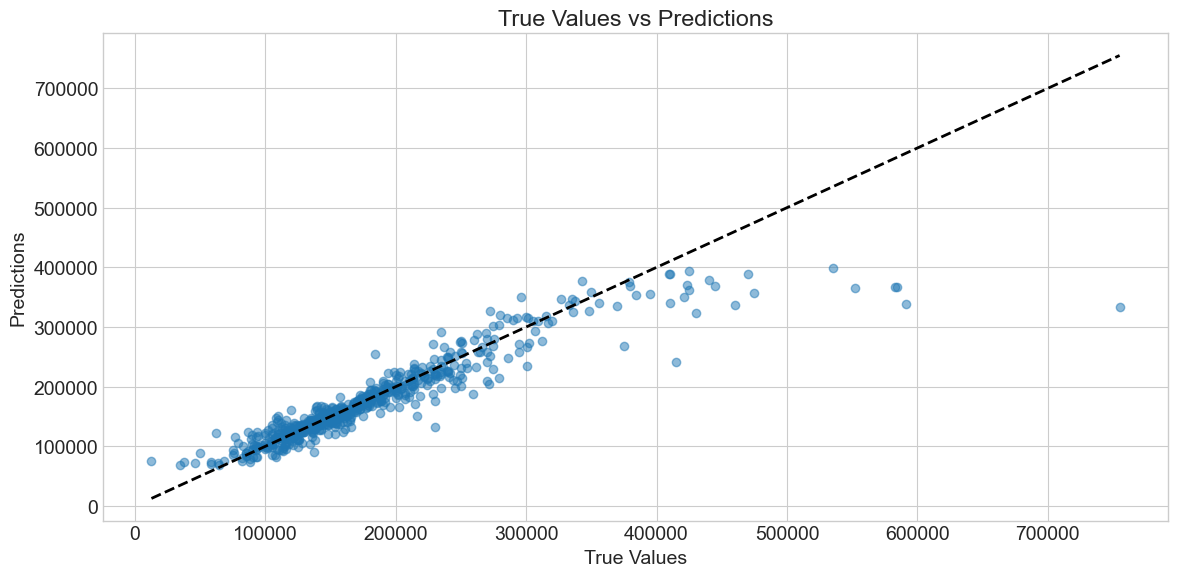

In [246]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_value, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.savefig('y_test_vs_y_pred.png')
plt.show()

Como vamos utilizar o modelo normalmente?

Para utilizar o modelo para prever de fácil aceso, vamos fazer uma api Flask, para isso, iniciamos guardando o modelo em um arquivo, para passar para um diretório onde a api irá rodar.

In [ ]:
_ = jbl.dump(chosen_model, 'model.pkl')

['model.pkl']

Agora vamos criar um body de exemplo para passar para a api de previsão

In [286]:
X_test_ = X_test.copy()

X_test_.reset_index(drop=True, inplace=True)

predicting_n = 3

example_house = dict(X_test_.iloc[predicting_n])
for k, v in example_house.items():
    if isinstance(v, np.int64):
        example_house[k] = int(v)
    elif isinstance(v, np.float64):
        example_house[k] = float(v)

example_house


{'MS.SubClass': 50,
 'MS.Zoning': 'RL',
 'Lot.Frontage': 82.0,
 'Lot.Area': 14235,
 'Street': 'Pave',
 'Alley': nan,
 'Lot.Shape': 'IR1',
 'Land.Contour': 'Lvl',
 'Utilities': 'AllPub',
 'Lot.Config': 'Inside',
 'Land.Slope': 'Gtl',
 'Neighborhood': 'SawyerW',
 'Condition.1': 'Norm',
 'Condition.2': 'Norm',
 'Bldg.Type': '1Fam',
 'House.Style': '1.5Fin',
 'Overall.Qual': 6,
 'Overall.Cond': 8,
 'Year.Built': 1900,
 'Year.Remod.Add': 1993,
 'Roof.Style': 'Gable',
 'Roof.Matl': 'CompShg',
 'Exterior.1st': 'Wd Sdng',
 'Exterior.2nd': 'Plywood',
 'Mas.Vnr.Type': nan,
 'Mas.Vnr.Area': 0.0,
 'Exter.Qual': 'TA',
 'Exter.Cond': 'TA',
 'Foundation': 'PConc',
 'Bsmt.Qual': 'Fa',
 'Bsmt.Cond': 'Gd',
 'Bsmt.Exposure': 'No',
 'BsmtFin.Type.1': 'Unf',
 'BsmtFin.SF.1': 0.0,
 'BsmtFin.Type.2': 'Unf',
 'BsmtFin.SF.2': 0.0,
 'Bsmt.Unf.SF': 676.0,
 'Total.Bsmt.SF': 676.0,
 'Heating': 'GasA',
 'Heating.QC': 'TA',
 'Central.Air': 'Y',
 'Electrical': 'SBrkr',
 'X1st.Flr.SF': 831,
 'X2nd.Flr.SF': 614,
 'Low.

Vamos chamar a api

In [288]:
# Chamando a api com o body dos dados

import requests
import json

url = "http://18.231.253.225:8080/api/v1/predict"
data = example_house

headers = {
    'Content-Type': 'application/json'
}

try:
    response = requests.post(url, data=json.dumps(data), headers=headers)
except requests.exceptions.RequestException as e:
    print(f"Error: {e}")
    response = None


predicted_value = response.json()["predicted_value"]




Por último, vamos testar a previsão

In [289]:
print("valor predito:", predicted_value, "\nvalor real:", y_test.iloc[predicting_n], "\nRMSE:", rmse)

valor predito: 148168.875 
valor real: 138500 
RMSE: 34573.32891117082
